# Yu-Gutnisky-2016 - A DataJoint example
This notebook presents data and results associated with the following papers:

>Jianing Yu, Diego A Gutnisky, S Andrew Hires & Karel Svoboda1. "Layer 4 fast-spiking interneurons filter thalamocortical signals during active somatosensation" (2016) Nat Neurosci (https://dx.doi.org/10.1038/nn.4412)

Original data shared here: http://crcns.org/data-sets/ssc/ssc-7

The data in original NWB 1 format (.nwb) have been ingested into a DataJoint data pipeline presented below. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper.

In [1]:
from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis, virus,
                      intracellular, extracellular, behavior, utilities)

Connecting root@127.0.0.1:3306


In [2]:
%matplotlib inline 

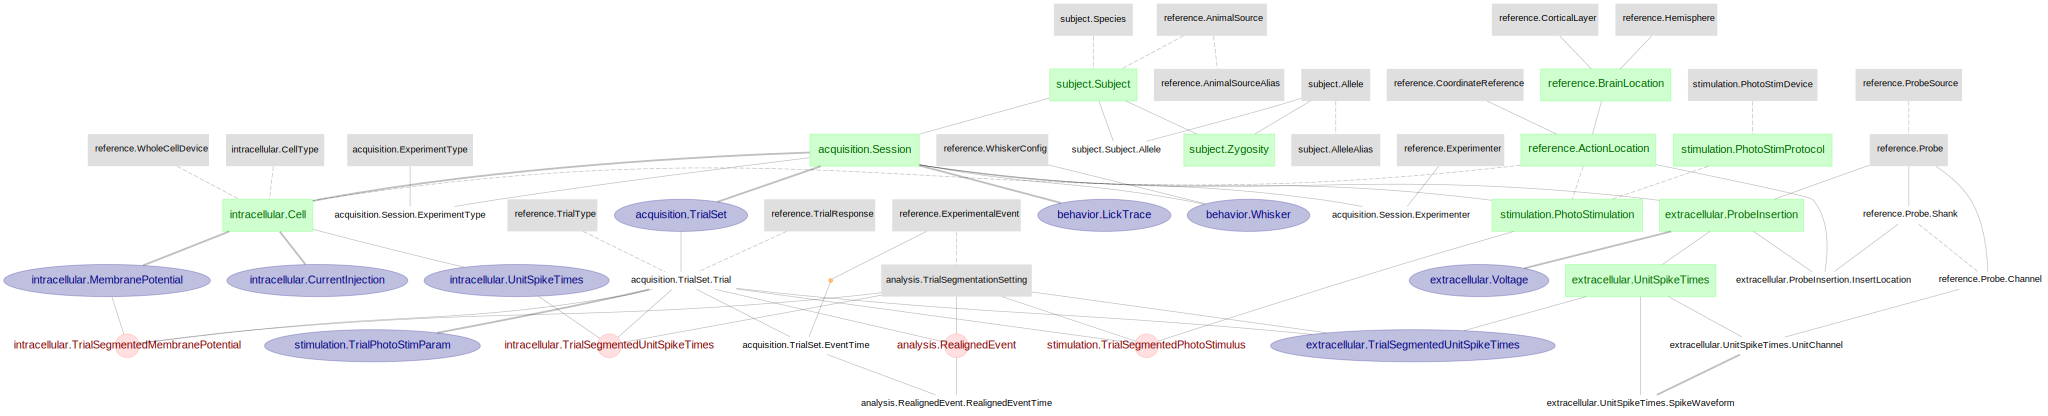

In [16]:
all_erd = (dj.ERD(reference) + dj.ERD(subject)
           + dj.ERD(acquisition) + dj.ERD(analysis)
           + dj.ERD(stimulation) + dj.ERD(behavior)
           + dj.ERD(extracellular) + dj.ERD(intracellular))
dj.ERD(all_erd)

### Replication of Figure 1 (g, h, i, j) - L4 excitatory cell

In [3]:
cell_key = intracellular.Cell & {'session_id': 'JY1243AAAA'}

In [4]:
cell_key * behavior.Whisker

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,whisker_config,cell_type,brain_region,brain_subregion,cortical_layer layer within cortex,hemisphere,coordinate_ref,"coordinate_ap in mm, anterior positive, posterior negative","coordinate_ml in mm, always postive, number larger when more lateral","coordinate_dv in mm, always postive, number larger when more ventral (deeper)",device_name,principal_whisker is this the principal whisker,distance_to_pole,block_mask,touch_offset,touch_onset,whisker_angle,whisker_curvature,behavior_timestamps (s)
anm244028,2014-10-21 00:00:00,JY1243AAAA,C2,Excitatory,barrel cortex,N/A,4,left,bregma,1.80,3.50,0.47,Multiclamp 700B,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [5]:
trial_start, trial_stop = (acquisition.TrialSet.Trial & cell_key).fetch('start_time', 'stop_time')

In [6]:
# get behavioral data from the principal whisker
dis_to_pole, touch_on, touch_off, whisk_pos, whisk_curv, b_tvec = (behavior.Whisker & cell_key & 'principal_whisker=1').fetch1(
    'distance_to_pole', 'touch_onset', 'touch_offset', 'whisker_angle', 'whisker_curvature', 'behavior_timestamps')

In [7]:
touch_on = np.where(touch_on==1, touch_on, np.nan)
touch_off = np.where(touch_off==1, touch_off, np.nan)

In [8]:
Vm, v_tvec = (intracellular.MembranePotential & cell_key).fetch1('membrane_potential', 'membrane_potential_timestamps')
spike_times = (intracellular.UnitSpikeTimes & cell_key).fetch1('spike_times')
lick_traces = (behavior.LickTrace & cell_key).fetch1('lick_trace')

#### Perform segmentation aligning to trial-start

In [9]:
# segment: 0 to 5s of trial_start
event_times = trial_start
pre_dur = 0
post_dur = 5
v_fs = round(1/np.median(np.diff(v_tvec)))
b_fs = round(1/np.median(np.diff(b_tvec*1e3)))

In [10]:
seg_vtvec = np.linspace(-pre_dur, post_dur, int((post_dur+pre_dur)*v_fs))
seg_btvec = np.linspace(-pre_dur, post_dur, int((post_dur+pre_dur)*b_fs))

In [13]:
segmented_spikes = [spike_times[np.logical_and(spike_times > t - pre_dur, 
                                                   spike_times < t + post_dur)] for t in event_times]
segmented_Vm = np.vstack([Vm[range(int(np.where(np.abs(v_tvec-t)<5e-4)[0][0] - pre_dur * v_fs),
                                       int(np.where(np.abs(v_tvec-t)<5e-4)[0][0] + post_dur * v_fs))]
                              for t in event_times])
segmented_lick_traces = np.vstack([lick_traces[range(int(np.where(np.abs(v_tvec-t)<5e-4)[0][0] - pre_dur * v_fs),
                                                 int(np.where(np.abs(v_tvec-t)<5e-4)[0][0] + post_dur * v_fs))]
                               for t in event_times])

In [14]:
segmented_behav = {k: np.vstack([d[range(int(np.where(np.abs(b_tvec-t)<5e-4)[0][0] - pre_dur * b_fs),
                                         int(np.where(np.abs(b_tvec-t)<5e-4)[0][0] + post_dur * b_fs))]
                                 for t in event_times]) 
                   for k, d in zip(('dis_to_pole', 'touch_on', 'touch_off', 'whisk_pos', 'whisk_curv'), 
                                   (dis_to_pole, touch_on, touch_off, whisk_pos, whisk_curv))}

#### Figure 1g

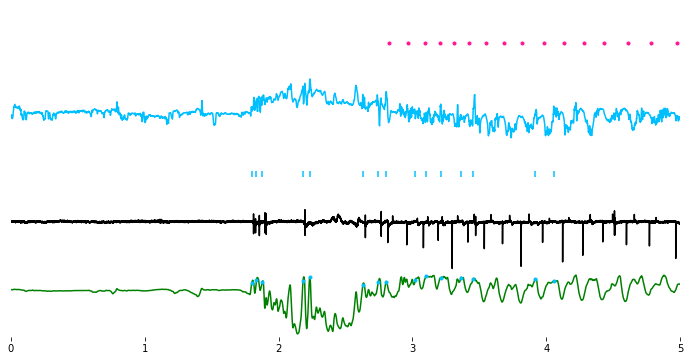

In [15]:
trial_num = 5
fig1a, axs = plt.subplots(5, 1, figsize=(12, 6))
fig1a.subplots_adjust(hspace=0.01)

axs[0].plot(seg_vtvec, np.where(segmented_lick_traces[trial_num, :] > 0, segmented_lick_traces[trial_num, :], np.nan),
            '.', color='deeppink')
axs[1].plot(seg_btvec, segmented_behav['whisk_curv'][trial_num, :], 'deepskyblue')
axs[2].scatter(segmented_spikes[trial_num], np.full_like(segmented_spikes[trial_num], 1), c='k', marker='|', linewidths=5)
axs[2].scatter(seg_btvec[segmented_behav['touch_on'][trial_num, :]==1],
               np.full_like(seg_btvec[segmented_behav['touch_on'][trial_num, :]==1], 1),
               c='deepskyblue', marker='|', linewidths=5)
axs[3].plot(seg_vtvec, segmented_Vm[trial_num, :], 'k')
axs[4].plot(seg_btvec, segmented_behav['whisk_pos'][trial_num, :], 'g')
axs[4].plot(seg_btvec, segmented_behav['whisk_pos'][trial_num, :]*segmented_behav['touch_on'][trial_num, :], '.', c='deepskyblue')

for a in axs:
    a.set_xlim((-pre_dur, post_dur))
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.set_yticks([])
for a in axs[:-1]:
    a.set_xticks([])

#### Build touch-triggered PSTH 

In [19]:
# touch times
# touch_onset = b_tvec[touch_on==1]
# touch_offset = b_tvec[touch_off==1]
touch_onset = np.array([t for t in (segmented_behav['touch_on'] * seg_btvec + np.array([trial_start]).T).flatten() if not np.isnan(t)])
touch_offset = np.array([t for t in (segmented_behav['touch_off'] * seg_btvec + np.array([trial_start]).T).flatten() if not np.isnan(t)])
# inter-touch-interval - of each touch
iti = (touch_onset[1:] - touch_offset[:-1]) 

In [20]:
# get touch-onset that has inter-touch-interval of at least 25ms
touch_onset = touch_onset[:-1][iti > 25e-3]

In [21]:
# segment: -25ms to 50ms of touch-time
pre_touch = 25e-3
post_touch = 50e-3
v_fs = round(1/np.median(np.diff(v_tvec)))
t_vec = np.linspace(-pre_touch, post_touch, int((post_touch+pre_touch)*v_fs)) * 1e3

In [22]:
# touch-aligned spike-times
touch_aligned_spikes = [spike_times[np.logical_and(spike_times > t_touch - pre_touch, 
                                                   spike_times < t_touch + post_touch)] for t_touch in touch_onset]

In [23]:
# touch-aligned membrane potential
touch_aligned_Vm = np.vstack([Vm[range(int(np.where(np.abs(v_tvec-t_touch)<1e-4)[0][0] - pre_touch * v_fs),
                                       int(np.where(np.abs(v_tvec-t_touch)<1e-4)[0][0] + post_touch * v_fs))]
                              for t_touch in touch_onset])

In [24]:
# trial-average spike histogram
def build_PSTH(spike_times, timerange, bin_size=0.05):
    spk_counts, spk_edges = np.histogram(np.hstack(r for r in spike_times),
                                         bins=int((timerange[-1] - timerange[0]) / bin_size)
                                         , range=timerange)
    spk_rates = spk_counts / np.diff(spk_edges) / len(spike_times)
    return spk_rates, spk_edges[:-1]

In [28]:
spk_rates, spk_edges = build_PSTH(touch_aligned_spikes, (t_vec[0], t_vec[-1]), bin_size=0.001)

In [ ]:
fig1cd, axs = plt.subplots(2, 1, figsize=(4, 4))
axs[0].plot(t_vec, touch_aligned_Vm.mean(axis=0));
axs[0].set_ylabel('Membrane Potential (mV)')
axs[1].bar(spk_edges, spk_rates);
axs[1].set_ylabel('Spikes')
axs[1].set_xlabel('Time from touch onset')